In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda,RepeatVector,Dot
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape,merge,Concatenate
import keras.backend as K
import math
from keras.activations import softmax,tanh
import tensorflow as tf
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 480469909892993924, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11266549351
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14136414054668516687
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
cnn_base = VGG16(input_shape=(448,448,3),include_top=False,weights='imagenet')

In [4]:
cnn_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 448, 448, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 448, 448, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 448, 448, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 224, 224, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 224, 224, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 224, 224, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 112, 112, 128)     0         
__________

In [22]:
def attention_block(x,K,labels,w,h):
    H = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    spatial_softmax = Lambda(lambda x:softmax(H,axis=3))(H)
    O = Conv2D(labels*K, kernel_size=(w, h), padding="same")(x)
    rH = Lambda(lambda x:keras.backend.repeat_elements(x, rep=labels, axis=3))(spatial_softmax)
    o = Lambda(lambda x: tf.einsum('bijk,bijk->bk',x[0],x[1]))([O,rH])
    tempH = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    gh = Lambda(lambda x: softmax(tanh(tf.einsum('bijk,bijk->bk',x[0],x[1])),axis=1))([tempH,spatial_softmax])
    rgh = Lambda(lambda x:keras.backend.repeat_elements(x, rep=labels, axis=1))(gh)
    of = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([rgh,o])
    new_shape = Reshape((K,labels))(of)
    out = Lambda(lambda x: keras.backend.sum(x,axis=1))(new_shape)
    return out

In [9]:
# K = 3
# labels = 22
# w,h = 10,10

# for layer in cnn_base.layers:
#     if layer.name=='block5_conv3':
#         break
#     layer.trainable = False

x = cnn_base.get_layer('block3_conv3').output
x = MaxPooling2D(pool_size=(16, 16))(x)
x = Conv2D(1024, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(7, 7))(x)
x = BatchNormalization()(x)
x = Conv2D(22, kernel_size=(1, 1), padding="same")(x)
y = Reshape((22,),name='localization_output1')(x)


# x = cnn_base.get_layer('block3_conv3').output
# final1 = attention_block(x,K,labels,w,h)

# x = cnn_base.get_layer('block4_conv3').output
# final2 = attention_block(x,K,labels,w,h)


x = cnn_base.get_layer('block5_pool').output
x = Conv2D(1024, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(4, 4))(x)
x = BatchNormalization()(x)
x = Conv2D(1024, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(22, kernel_size=(1, 1), padding="same")(x)
x = Reshape((22,),name='localization_output2')(x)

losses = {
    "localization_output1": "mean_squared_error",
    "localization_output2": "mean_squared_error",
}
lossWeights = {"localization_output1": 1.0, "localization_output2": 1.0}

model = Model(inputs=cnn_base.input, outputs=[x,y])
model.compile(loss=losses, loss_weights=lossWeights,optimizer="adam", metrics=['accuracy'])
print(model.summary())
initial_weights = model.get_weights()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 448, 448, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 448, 448, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 448, 448, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 224, 224, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [ ]:
train_pred = []
test_pred = []

train_scores = []
test_scores = []

history_record = []

for i in range(5):
    print("Loading file")
    with open('data-localize-landmarks'+str(i)+'.pckl','rb') as file:
        all_images,all_landmarks,all_bboxes,all_image_sizes,test_images,test_landmarks,test_bboxes,test_image_sizes = pickle.load(file)
    try:
        with open('landmarks_localization_vgg16_attention'+str(i)+'.hd5','rb') as f:
            model_weights = pickle.load(f)
            print("loaded model")
    except:
        print("setting initial weights")
        model_weights = initial_weights
    model.set_weights(model_weights)
    print("loaded")
    history = model.fit(x=np.array(all_images),y=[np.array(all_landmarks),np.array(all_landmarks)],batch_size=5,epochs=30,
                       validation_data=(np.array(test_images),[np.array(test_landmarks),np.array(test_landmarks)]))
    history_record.append(history)
    train_score = model.evaluate(x=np.array(all_images),y=np.array(all_landmarks),batch_size=50)
    test_score = model.evaluate(x=np.array(test_images),y=np.array(test_landmarks),batch_size=50)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print("predicting")
    print("Test Score",test_score)
    train_predictions = model.predict(x=np.array(all_images),batch_size=50)
    test_predictions = model.predict(x=np.array(test_images),batch_size=50)
    
    train_pred.append(train_predictions)
    test_pred.append(test_predictions)
    
    try:
        with open('landmarks_localization_vgg16'+str(i)+'.hd5','wb') as f:
            pickle.dump(model.get_weights(),f)
    except Exception as ex:
        print("Could not write",ex)

Loading file
setting initial weights
loaded
Train on 906 samples, validate on 76 samples
Epoch 1/30
906/906 [==============================] - 178s 197ms/step - loss: 61222.4676 - localization_output2_loss: 5266.6754 - localization_output1_loss: 55955.7921 - localization_output2_acc: 0.3444 - localization_output1_acc: 0.2031 - val_loss: nan - val_localization_output2_loss: 3594.1045 - val_localization_output1_loss: nan - val_localization_output2_acc: 0.4079 - val_localization_output1_acc: 0.0000e+00
Epoch 2/30
906/906 [==============================] - 165s 182ms/step - loss: 25197.2863 - localization_output2_loss: 1926.4683 - localization_output1_loss: 23270.8179 - localization_output2_acc: 0.4172 - localization_output1_acc: 0.0276 - val_loss: nan - val_localization_output2_loss: 1273.2309 - val_localization_output1_loss: nan - val_localization_output2_acc: 0.4605 - val_localization_output1_acc: 0.0000e+00
Epoch 3/30
906/906 [==============================] - 165s 182ms/step - loss: 5

In [46]:
historys = []
for hist in history_record:
    historys.append(hist.history)
    
with open('vgg16-landmark-predictions.pckl','wb') as file:
    pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)

In [51]:
with open('vgg16-landmark-predictions.pckl','rb') as vgg16:
    train_pred,test_pred,historys,train_scores,test_scores = pickle.load(vgg16)

In [52]:
def global_localization_error(test_pred,test_landmarks):
    error = 0
    for idx in range(len(test_landmarks)):
        for set_num in range(11):
            predx,predy = test_pred[idx][2*set_num],test_pred[idx][2*set_num+1]
            x,y  = test_landmarks[idx][2*set_num],test_landmarks[idx][2*set_num+1]
            error = error + math.sqrt((predx-x)**2 + (predy-y)**2)
    return error/(len(test_landmarks)*11)

In [53]:
mean_error = []
for idx in range(5):
    with open('data-localize-landmarks'+str(idx)+'.pckl','rb') as file:
        all_images,all_landmarks,all_bboxes,all_image_sizes,test_images,test_landmarks,test_bboxes,test_image_sizes = pickle.load(file)
    mean_error.append(global_localization_error(test_pred[idx],test_landmarks))
print(sum(mean_error)/len(mean_error))

20.59936727203451


In [54]:
mean_error

[22.275676343760868,
 18.384346590105817,
 21.18174705604633,
 22.102819544481736,
 19.052246825777804]

In [22]:
len(test_landmarks[0])

22

-4.012045


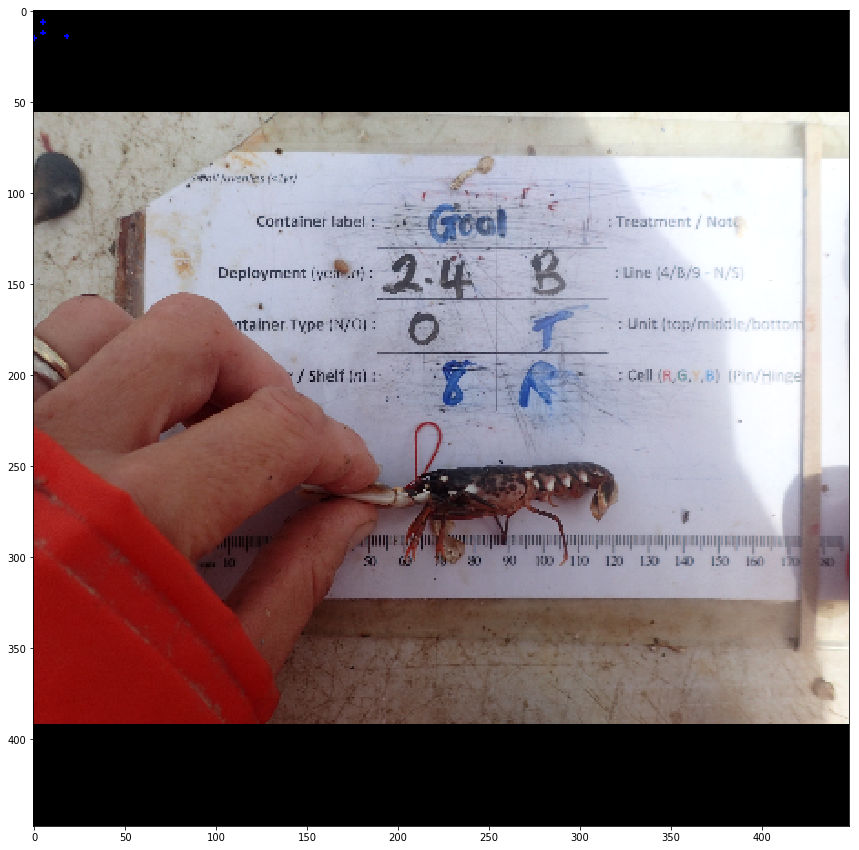

In [39]:
idx = 10
tuples = []
pred_landmarks = model.predict(np.expand_dims(np.array(test_images[idx]),0))[0]
print(pred_landmarks[0])
for i in range(11):
    tuples.append((pred_landmarks[i*2],pred_landmarks[i*2+1]))
for i in range(11):
    img = cv2.circle(test_images[idx],(int(tuples[i][0]),int(tuples[i][1])), 1, (0,0,255), -1)
pil_im = Image.fromarray(img)
plt.figure(figsize=(15,15))
plt.imshow(pil_im)

NameError: name 'history' is not defined

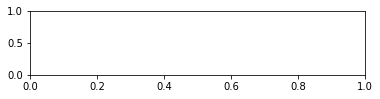

In [8]:
plt.subplot(3,1,1)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('Total Loss')
plt.show()
plt.subplot(3,1,2)
plt.plot(history.history['localization_output_iou_metric'])
plt.xlabel('epochs')
plt.ylabel('IoU Metric')
plt.show()
plt.subplot(3,1,3)
plt.plot(history.history['classification_output_loss'])
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [18]:
from sklearn import preprocessing
import numpy
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('classes.npy')

In [22]:
idx = np.random.randint(low=0,high=np.array(test_images).shape[0])
bb,classify = model.predict(np.expand_dims(np.array(test_images)[idx],0))
[[xmin,ymin,xmax,ymax]]= bb
img = cv2.rectangle(np.array(test_images)[idx], (xmin,ymin), (xmax,ymax), (0,255,0), 4)
pil_im = Image.fromarray(img)
a = np.argmax(classify,axis=1)[0]
label = le.inverse_transform(np.argmax(classify,axis=1))
#print(label[0])
#y = ymin - 15 if ymin - 15 > 15 else ymin + 15
plt.title("Predicted: "+label[0]+", Actual: "+le.inverse_transform(np.argmax(test_predictions[idx])))
plt.imshow(pil_im)
print(label[0])

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


IndexError: list index out of range

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predicted_labels,labels=np.unique(labels_))
print(cm)

NameError: name 'labels_test' is not defined

In [ ]:
confusion_matrix(labels_test,predicted_labels)

labels_=list(np.unique(labels_test))
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_)
ax.set_yticklabels([''] + labels_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
idx = 101